#  <span style="color:orange">Data Ethics using Fairlearn </span>

#IMPORTANT INSTRUCTIONS
Please make a copy of this notebook, upload it into your own google drive and [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1gc1AAkYFDjHUk-PMVLZosxUk__4anNqQ#scrollTo=wsCySQTKB603)


# 1 Tutorial Objective
This tutorial will show you how to assess and mitigate fairness in machine learning models.

This tutorial is mostly based on combining various resources on the [Fairlearn website](https://fairlearn.org/).

This is not an exhaustive tutorial on how to use Fairlearn, but serves more as an introduction to ethics in machine learning and Fairlearn. Be aware that using Fairlearn, or any similar library or techniques, doesn't guarantee that your models are fair! Always know what you're modelling and what impact it can have on the end user!

This notebook is merely to demonstrate how to do an Fairness assessment and mitigation.

We use Colab for the ease of the demo, we do not advise to build your models within a notebooks. The goal is to have a visual easy to follow tutorial to best understand the different steps Fairness assesment and potential mitigation.


![Maintainer](https://dataroots.io/maintained-rnd.svg)

## 1.1 Pre-Requisites
This tutorial is tested using Python 3.7.15.

In [ ]:
!python --version

Python 3.7.15


## 1.2 Installing packages

We need to install the right version of all the python packages.

In [1]:
!printf 'fairlearn \npandas==1.3.5 \nxlrd==2.0.1 ' > requirements.txt
#!printf 'fairlearn' > requirements.txt

In [2]:
!pip install -q -r requirements.txt

     |████████████████████████████████| 177 kB 5.1 MB/s 
     |████████████████████████████████| 96 kB 5.4 MB/s 


# 2 Dataset for the Tutorial

For this tutorial we will be using the same the dataset from UCI called *Default of Credit Card Clients* Dataset. In the next steps we will explore this dataset.


#### Dataset Acknowledgements:
Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science.

The original dataset and data dictionary can be __[found here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)__ at the UCI Machine Learning Repository.

We'll go over the dataset in the next section and explain the data. 

# 3 Getting and Understanding Data

We will first get the data from the UCI website and inspect the first rows using the Pandas library.

In [134]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

# Modeling 
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics

from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score


df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', header=1, index_col=0)

print(df.head())

    LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   
3       90000    2          2         2   34      0      0      0      0   
4       50000    2          2         1   37      0      0      0      0   
5       50000    1          2         1   57     -1      0     -1      0   

    PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
ID         ...                                                                  
1      -2  ...          0          0          0         0       689         0   
2       0  ...       3272       3455       3261         0      1000      1000   
3       0  ...      14331      14948      15549      1518      1500      1000   
4       0  ...      28314      28959      29547      2000     

### Dataset features 

This dataset contains information on default payments, demographic factors, credit data, payment history, and billing statements of credit card clients in Taiwan from April 2005 to September 2005. There are 25 features. Short descriptions of each column are as follows:

- **ID**: ID of each client
- **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- **SEX**: Gender (1=male, 2=female)
- **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
- **AGE**: Age in years
- **PAY_0 to PAY_6**: Repayment status by n months ago (PAY_0 = last month ... PAY_6 = 6 months ago) (Labels: -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- **BILL_AMT1 to BILL_AMT6**: Amount of bill statement by n months ago ( BILL_AMT1 = last_month .. BILL_AMT6 = 6 months ago)
- **PAY_AMT1 to PAY_AMT6**: Amount of payment by n months ago ( BILL_AMT1 = last_month .. BILL_AMT6 = 6 months ago)
- **default**: Default payment (1=yes, 0=no) `Target Column`

## Manipulating data to introduce artificial sensitivity


Here we introduce some synthetic signal in the data that makes the outcome variable highly correlated with the "female" group. We will then use assessment techniques to see if we can indeed spot the influence of this manipulation, and mitigate our model accordingly.

In [135]:
# Extract the sensitive feature
sensitive = df["SEX"]
sensitive_str = A.map({ 2:"female", 1:"male"})
# Extract the target
Y = df["default payment next month"]
categorical_features = ['EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in categorical_features:
    df[col] = df[col].astype('category')

In [136]:
dist_scale = 0.5
np.random.seed(42)
# Make 'LIMIT_BAL' informative of the target
df['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=df.shape[0])
# But then make it uninformative for the male clients
df.loc[sensitive==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=df[sensitive==1].shape[0])

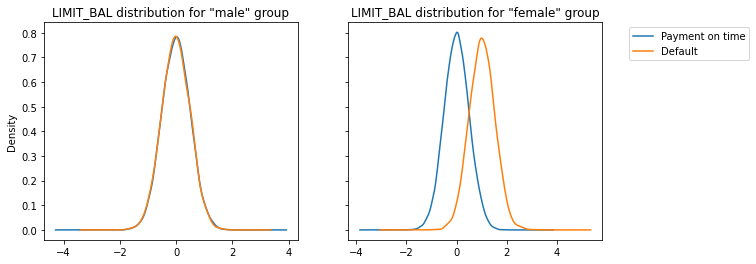

In [137]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for men
df['LIMIT_BAL'][(sensitive==1) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax1, 
                                           title="LIMIT_BAL distribution for \"male\" group")
df['LIMIT_BAL'][(sensitive==1) & (Y==1)].plot(kind='kde', label="Default", ax=ax1)
# Plot distribution of LIMIT_BAL for women
df['LIMIT_BAL'][(sensitive==2) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for \"female\" group")
df['LIMIT_BAL'][(sensitive==2) & (Y==1)].plot(kind='kde', label="Default", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

## Prepare data for training a model

In [138]:
# Train-test split

df_train, df_test, Y_train, Y_test, sensitive_train, sensitive_test, sensitive_str_train, sensitive_str_test = train_test_split(
    df.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    sensitive, 
    sensitive_str,
    test_size = 0.3, 
    random_state=42,
    stratify=Y)

# 4 Training a Model

We will now train a model on the data. The aim here is to illustrate that Fairlearn can pick up on the manipulation we introduced in the data.

In [139]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}
model = lgb.LGBMClassifier(**lgb_params)
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [140]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

## Looking at model performance and feature importance

roc_auc: 0.8597825493894053


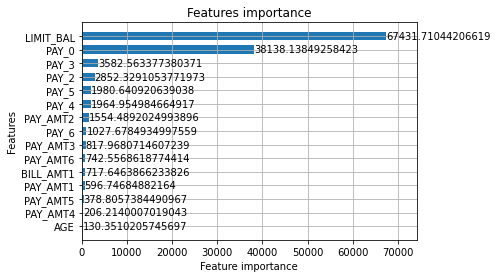

In [141]:
# Train AUC
print("roc_auc:", roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1]))

# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance", importance_type="gain", max_num_features=15) 
plt.show()

Here we clearly see that LIMIT_BAL is the most important feature. Which is expected because we added some artifical signal. Important here is that we added that signal for only one group of the senstive feature (SEX). This means the model is performing really well for the female group, but is doing nothing for the male group. 

# 5 Using Fairlearn

Fairlearn comes with some functions that automatically calculate and display relevant metrics to assess the fairness of your model. It also allows to see the result for all levels of the sensitive features, like in the example below.

## 5.1 Assessment

In [142]:
mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=sensitive_str_test)

mf.by_group

/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)


,FPR,FNR
SEX,,
female,0.155959,0.138475
male,0.162551,0.514118


We see that false positives and false negatives are more common for the Male group. The function below calculates some of the key assessment metrics. A good starting point for more detail on these can be found [here](https://fairlearn.org/v0.8/user_guide/assessment/common_fairness_metrics.html#equalized-odds).

In [143]:
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [145]:
# Metrics
models_dict = {"Light GBM": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, sensitive_str_test)

,Light GBM
Overall selection rate,0.278556
Demographic parity difference,0.064342
Demographic parity ratio,0.788367
------,
Overall balanced error rate,0.228678
Balanced error rate difference,0.191117
------,
False positive rate difference,0.006592
False negative rate difference,0.375643
Equalized odds difference,0.375643


While we once again see that overall performance is quite good, performance in the different subgroups point towards issues, though still rather modest. In the next section we'll explore a technique that can mitigate the impact on our model.

## 5.2 Mitigation

We'll now use a Threshold optimizer procedure to ensure that the equalized odds are optimized. This essentially means that the model is adjusted in such a way that it performs equally well in all groups of the sensitive feature.  This algorithm finds a suitable threshold for the scores (class probabilities) produced by the lightgbm model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that ThresholdOptimizer is effectively optimizing balanced accuracy on the original data.

In [151]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
sensitive_train_balanced = sensitive_train.loc[pp_train_idx]
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=sensitive_train_balanced)
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=sensitive_test)
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, sensitive_str_test)

/usr/local/lib/python3.7/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:275: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:309: UserWarning: The value of `prefit` is `True`, but `check_is_fitted` raised `NotFittedError` on the base estimator.

If the provided base estimator has been fitted, this could mean that (1) its implementation does not conform to the sklearn estimator API, or (2) the enclosing ThresholdOptimizer has been cloned (for instance by `sklearn.model_selection.cross_validate`).

In case (1), please file an issue with the base estimator developers, but continue to use the enclosing ThresholdOptimizer with `prefit=True`. In case (2), please use `prefit=False`.
  type(s

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.278556,0.095
Demographic parity difference,0.064342,0.01046
Demographic parity ratio,0.788367,0.89676
------,,
Overall balanced error rate,0.228678,0.3946
Balanced error rate difference,0.191117,0.009876
------,,
False positive rate difference,0.006592,0.008889
False negative rate difference,0.375643,0.010863
Equalized odds difference,0.375643,0.010863


# 6 Conclusion

We observe a clear improvement in fairness, as expected! But in order to improve fairness we had to compromise on overall model performance. Notice that the overall AUC went from 0,84 to 0,60. This kind of trade-off is inherent to fairness mitigation techniques. Of course this is a huge difference, but that is due to the artifical nature of this toy example. Nonetheless, an important consideration will always have to be done: how much of my model performance am I willing to give up to increase fairness? 

Grid search techniques exist to map out this trade-off. Based on grid search results a debate between a machine learning engineer/date scientist and their business partner is needed to make the decision.